In [4]:
import numpy as np
import pandas as pd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [116]:
df_ds = pd.read_csv('./job_summaries/output_data_scientist.csv')
df_da = pd.read_csv('./job_summaries/output-data-analyst.csv')
df_de = pd.read_csv('./job_summaries/output-data-engineer.csv')
df_bi = pd.read_csv('./job_summaries/output-bi.csv')

df_da.shape
frames = pd.concat([df_ds, df_da, df_de, df_bi])
frames.shape

(3187, 3)

In [7]:
skills_json = pd.read_json('/Users/dav2802/PycharmProjects/indeedcrawler/linkedin_topics_7-23-17.json')

In [47]:
toto = skills_json.apply(lambda x : list(chain.from_iterable([list(x['skills'].keys()) if x['skills'] is not None else [], x['topSkills'] if x['topSkills'] is not None else []])), axis = 1)

['Network Administration',
 'Microsoft Office',
 'Active Directory',
 'Technical Support',
 'Customer Service',
 'Computer Hardware',
 'Network + Certified',
 'Troubleshooting',
 'Networking',
 'Windows 7',
 'Network + Certified',
 'Computer Hardware Troubleshooting',
 'Windows 10',
 'Printer Support',
 'Laptops',
 'Cisco Routers',
 'Computer Repair',
 'Computer Security',
 'Wireless Networking']

In [52]:
from itertools import chain

list(set(chain.from_iterable(list(skills_json.apply(lambda x : list(chain.from_iterable([list(x['skills'].keys()) if x['skills'] is not None else [], x['topSkills'] if x['topSkills'] is not None else []])), axis = 1)))))

['Data Mining',
 'Polymer Blends',
 'T-1',
 'Corporate Sponsorships',
 'Stem Cell Research',
 'Data Center Construction',
 'OSSTMM',
 'Donor Engagement',
 'Receptor Pharmacology',
 'MediaMind',
 'Heat',
 'Fastlane',
 'Program Administration',
 'Community Theatre',
 'IGCC',
 'Ubuntu',
 'Blown Film',
 'Stained Glass',
 'Mentor Graphics',
 'IBM Rational System Architect',
 'Global Macro',
 'Real-time Control Systems',
 'Marine Safety',
 'Mazda',
 'Training',
 'International Conferences',
 'Emerging Payments',
 'Design Consulting',
 'Stone Setting',
 'Scope Planning',
 'Celebrity Seeding',
 'Bodypaint',
 'Washing',
 'Golf Courses',
 'State Policy',
 'Invasive Species',
 'Interdisciplinary Teaching',
 'Software Solution Architecture',
 'Toggle',
 'Zero Waste',
 'Individual Assessment',
 'Technical Service Delivery',
 'Rehabilitation Counseling',
 'Handball',
 'Swine',
 'Modula-2',
 'Tender Management',
 'Receptor Binding Assays',
 'Threat Management',
 'ISDN User Part (ISUP)',
 'Luggage',
 

In [83]:
ml_df = skills[skills.skills.apply(lambda x: 'Machine Learning' in x.keys() if x is not None else False )]

In [114]:
print(ml_df[ml_df.name == 'Unsupervised Learning'].topSkills.iloc[0])
ml_df[ml_df.name == 'Unsupervised Learning'].skills.iloc[0]

['Classifiers', 'Dimensionality Reduction', 'Feature Selection', 'Feature Extraction', 'Association Rules', 'Collaborative Filtering', 'Anomaly Detection', 'Unstructured Data', 'Reinforcement Learning']


{'C++': 410,
 'Data Analysis': 462,
 'Data Mining': 423,
 'Java': 396,
 'Machine Learning': 845,
 'Matlab': 459,
 'Python': 716,
 'R': 520,
 'SQL': 477,
 'Statistics': 350}

In [92]:
skills_list = ['python', 'sql', 'hadoop', 'spark', 'aws', 'r', 'big data', 'machine learning', 'deep learning',
               'sklearn', 'scikit-learn', 'HTML5' , 'javascript', 'jquery', 'excel', 'powerpoint', 'scala', 'java',
              'c++', 'hive', 'NLP', 'CART', 'SVM', 'regression', 'statistics', 'mapreduce', 'tableau', 'PyTorch' , 'TensorFlow', 
               'Theano', 'Keras', 'algorithms', 'Linear Models', 'Neural Networks', 'Decision Trees', 'Bayesian', 'Clustering',
               'Anomaly Detection', 'data mining']

In [55]:
from collections import Counter
import re
import matplotlib.pylab as plt
%matplotlib inline

class SkillsExtractor():
    
    def __init__(self, job_summaries_df, skills_list, nb_top_skills, job_title):
        self.job_summaries_df = job_summaries_df
        self.skills_list = skills_list
        self.nb_top_skills = nb_top_skills
        self.job_title = job_title
        
    def get_occurences(self, textfile):

        skills_dict  = {x : 0 for x in self.skills_list}

        cnt = Counter()
        words = re.findall('[A-Za-z+]+', textfile.lower())
        skills_dict = {skill.title() : 100 if Counter(words)[skill] > 0 else 0 for skill, ind in skills_dict.items()}
        
        # Deal with double word skill
    
        for skill in list(skills_dict.keys()):
            if ' ' in skill:                
                double_word_skill = re.findall(skill.lower(), textfile.lower())
                skills_dict[skill.title()] = 100 if len(double_word_skill) > 0 else 0 
        return skills_dict

    def get_skills_df(self, column_name):

        skills_df = pd.DataFrame(columns=[x.title() for x in self.skills_list])

        for ind, job_desc in enumerate(self.job_summaries_df[column_name]):
            if ind % 200 == 0:
                print("Job description n°%i" % ind)

            skills_occurences = self.get_occurences(job_desc)
            skills_df = skills_df.append(skills_occurences, ignore_index = True)

        return skills_df

    def extract_skills(self, column_name):

        new_df = self.job_summaries_df.copy()
        skills_df = self.get_skills_df(column_name)
        new_df = new_df.merge(skills_df, right_index=True, left_index=True)

        return new_df

    def get_top_n_skills_with_features(self, js_with_skills_df):
        
        skills_dict = js_with_skills_df[js_with_skills_df.columns[3:]].sum().apply(
            lambda x : x / len(js_with_skills_df)
        ).to_dict()
        
        top = self.nb_top_skills

        if top > len(skills_dict):
            top = len(skills_dict)
        
        top_n_skills = dict(Counter(skills_dict).most_common(top))
        
        return top_n_skills
    
    def get_top_skills(self, ):
        new_df_ds = self.extract_skills('summary')
        top_n_dict = self.get_top_n_skills_with_features(new_df_ds)

        print("The top %i skills are :" % self.nb_top_skills)
        for i in range(self.nb_top_skills):
            print("%i : %s (%.2f%%)" % 
                  (i+1, list(top_n_dict.keys())[i], list(top_n_dict.values())[i]))
        
        self.plot_top_skills(top_n_dict)
        return top_n_dict
    
    def plot_top_skills(self, top_dict):
        plt.figure(figsize = (15,8))
        plt.bar(range(len(top_dict)), list(top_dict.values()), align='center');
        plt.xticks(range(len(top_dict)), list(top_dict.keys()));
        plt.xlabel("Skills")
        plt.ylabel("% occurence among all job summaries")
        plt.title('Most important skills as a ' + self.job_title)
        

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 10 skills are :
1 : Python (66.79%)
2 : Machine Learning (62.01%)
3 : R (61.64%)
4 : Statistics (61.40%)
5 : Sql (47.43%)
6 : Algorithms (42.16%)
7 : Big Data (29.53%)
8 : Data Mining (28.55%)
9 : Hadoop (27.08%)
10 : Java (25.49%)


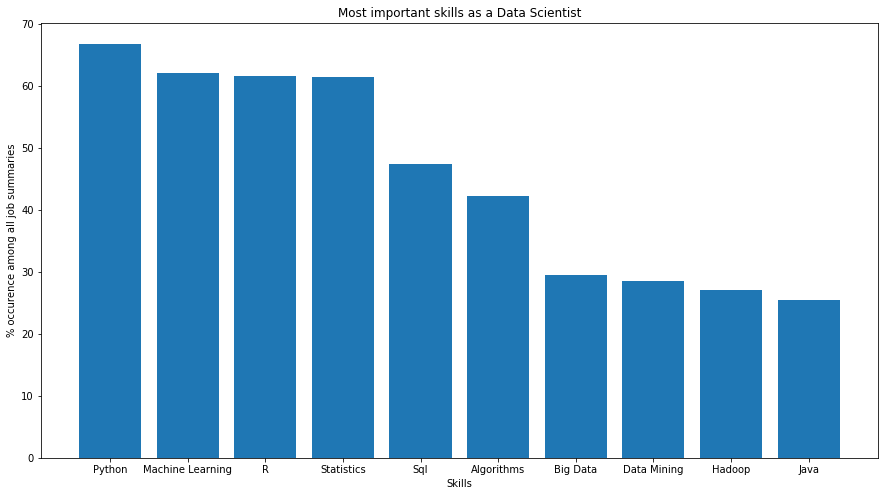

In [6]:
sk_ds = SkillsExtractor(df_ds, skills_list, 10, 'Data Scientist')
do_ds = sk_ds.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 10 skills are :
1 : Sql (57.03%)
2 : Excel (44.37%)
3 : Statistics (37.85%)
4 : R (28.52%)
5 : Python (27.75%)
6 : Tableau (22.12%)
7 : Machine Learning (15.86%)
8 : Data Mining (13.94%)
9 : Big Data (13.17%)
10 : Powerpoint (12.92%)


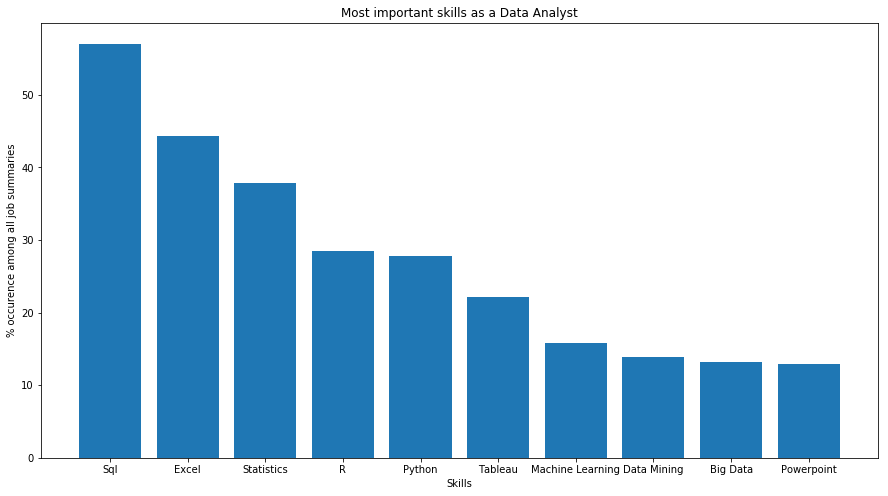

In [7]:
sk_da = SkillsExtractor(df_da, skills_list, 10, 'Data Analyst')
do_da = sk_da.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 10 skills are :
1 : Python (58.68%)
2 : Sql (52.68%)
3 : Java (45.44%)
4 : Big Data (40.57%)
5 : Hadoop (38.83%)
6 : Spark (37.45%)
7 : Machine Learning (27.59%)
8 : Aws (26.72%)
9 : Scala (20.85%)
10 : Hive (20.22%)


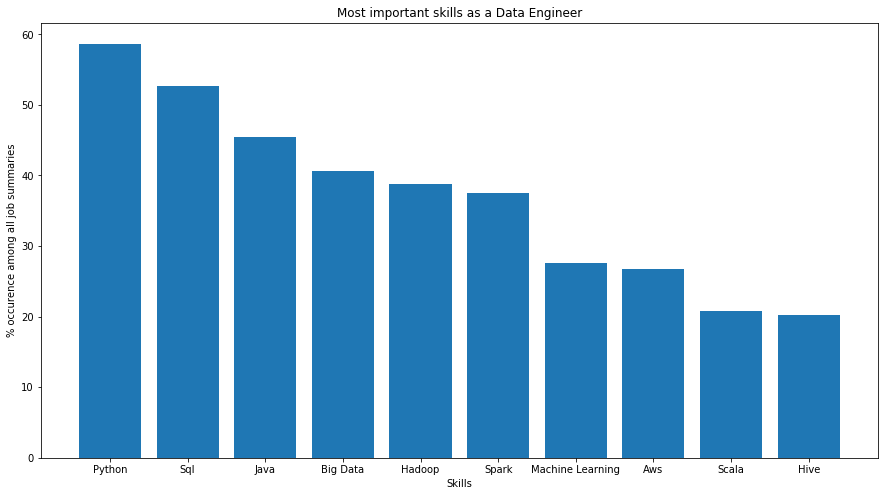

In [286]:
sk_de = SkillsExtractor(df_de, skills_list, 10, 'Data Engineer')
do_de = sk_de.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 10 skills are :
1 : Sql (71.07%)
2 : Tableau (38.32%)
3 : Excel (34.52%)
4 : Statistics (21.19%)
5 : Python (20.81%)
6 : R (18.78%)
7 : Big Data (15.99%)
8 : Hadoop (11.93%)
9 : Data Mining (9.77%)
10 : Powerpoint (9.52%)


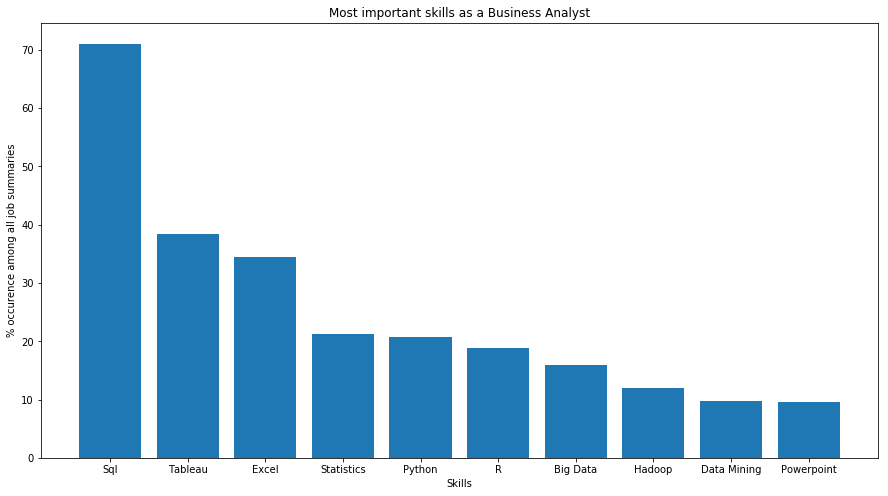

In [8]:
sk_bi = SkillsExtractor(df_bi, skills_list, 10, 'Business Analyst')
do_bi = sk_bi.get_top_skills()

In [41]:
df_ds_raw = frames['summary'].values
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b', # more than 3 characters
                                max_df = 0.5,  # Ten that appear in more than 50% of documents
                                min_df = 10) # Terms that appear in less than ten documents
dtm_tf = tf_vectorizer.fit_transform(df_ds_raw)
print(dtm_tf.shape)

(3187, 3714)


In [43]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_ds_raw)
print(dtm_tfidf.shape)

(3187, 3714)


In [56]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=100, random_state=0)
lda_tf.fit(dtm_tf)

/Users/joachimhagege/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=100, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [10]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=50, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/Users/joachimhagege/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=50, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [57]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
59     17.381939        1       1 -0.095384 -0.220405
10     11.206349        1       2 -0.097443 -0.160407
57     10.441608        1       3 -0.025121 -0.196403
4       7.817819        1       4 -0.169188 -0.018194
65      7.306221        1       5 -0.069924 -0.219063
51      4.333056        1       6 -0.025923 -0.128313
98      4.122786        1       7 -0.156330 -0.194646
90      4.067333        1       8 -0.100618 -0.092348
0       3.586244        1       9 -0.045174 -0.090230
71      3.254345        1      10 -0.094899 -0.207327
20      2.133671        1      11 -0.140448 -0.092408
44      1.517840        1      12 -0.312628  0.065996
72      1.457225        1      13 -0.276379  0.076978
35      1.455373        1      14 -0.196202 -0.085475
89      1.403800        1      15 -0.201608 -0.129811
79      1.387263        1      16 -0.185031 -0.106692
74      1.294472        1      17 -0.159660 -0.013695
69      1.235242        1      18 -0.239943 -0.075038
50      1.141374        1      19 -0.299074  0.019362
70      1.065857        1      20 -0.167838 -0.047215
53      1.029964        1      21 -0.150570 -0.093340
30      0.727765        1      22 -0.186912  0.018229
26      0.720026        1      23 -0.229365 -0.023627
85      0.703267        1      24 -0.185530  0.101622
99      0.692495        1      25 -0.222403 -0.094387
67      0.615792        1      26 -0.169803 -0.045624
86      0.571574        1      27 -0.195753 -0.050401
37      0.549100        1      28 -0.236938 -0.062262
49      0.462017        1      29 -0.208921 -0.040213
62      0.458158        1      30 -0.177701  0.009828
...          ...      ...     ...       ...       ...
3       0.007863        1      71  0.171493 -0.003716
2       0.007863        1      72  0.171474 -0.003738
25      0.007863        1      73  0.171493 -0.003716
66      0.007863        1      74  0.171449 -0.003756
27      0.007863        1      75  0.171433 -0.003777
28      0.007863        1      76  0.171494 -0.003715
60      0.007863        1      77  0.171494 -0.003716
82      0.007863        1      78  0.171475 -0.003734
58      0.007863        1      79  0.171445 -0.003767
83      0.007863        1      80  0.171493 -0.003716
55      0.007863        1      81  0.171445 -0.003770
54      0.007863        1      82  0.171485 -0.003728
84      0.007863        1      83  0.171494 -0.003716
76      0.007863        1      84  0.171484 -0.003729
48      0.007863        1      85  0.171493 -0.003716
47      0.007863        1      86  0.171465 -0.003753
46      0.007863        1      87  0.171452 -0.003771
45      0.007863        1      88  0.171472 -0.003750
91      0.007863        1      89  0.171493 -0.003717
43      0.007863        1      90  0.171414 -0.003866
42      0.007863        1      91  0.171440 -0.003784
39      0.007863        1      92  0.171477 -0.003732
38      0.007863        1      93  0.171493 -0.003717
36      0.007863        1      94  0.171491 -0.003719
80      0.007863        1      95  0.171493 -0.003716
34      0.007863        1      96  0.171476 -0.003738
33      0.007863        1      97  0.171428 -0.003813
61      0.007863        1      98  0.171494 -0.003716
77      0.007863        1      99  0.171481 -0.003729
75      0.007863        1     100  0.171442 -0.003779

[100 rows x 5 columns], topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
2306   Default  1516.000000     opportunity  1516.000000  30.0000  30.0000
1110   Default  1526.000000      employment  1526.000000  29.0000  29.0000
2844   Default  1043.000000        research  1043.000000  28.0000  28.0000
1177   Default  1309.000000           equal  1309.000000  27.0000  27.0000
2972   Default  2133.000000         science  2133.000000  26.0000  26.0000
1898  